# Imports

In [1]:
import pandas as pd
from datetime import timedelta
from sklearn.metrics import roc_auc_score, log_loss

In [2]:
df=pd.read_csv('../data/raw_data/historical_flights.csv')

In [3]:
df

,flight_id,dep_airport,dep_airport_group,arr_airport,arr_airport_group,service_type,std,sta,cancelled,atd,ata
0,WF149,HOV,B,OSL,NaN,J,2018-01-02T16:40:00.000000,2018-01-02T17:15:00.000000,0,NaN,2018-01-02T18:53:00.000000
1,WF722,OSL,NaN,MJF,D,J,2018-01-28T13:04:00.000000,2018-01-28T14:50:00.000000,0,NaN,NaN
2,WF188,FDE,A,OSL,NaN,J,2018-04-07T07:10:00.000000,2018-04-07T08:10:00.000000,0,NaN,2018-04-07T07:55:00.000000
3,WF176,HOV,B,OSL,NaN,J,2018-04-07T11:00:00.000000,2018-04-07T12:05:00.000000,0,NaN,2018-04-07T12:00:00.000000
4,WF148,HOV,B,OSL,NaN,J,2018-04-30T08:25:00.000000,2018-04-30T09:26:00.000000,0,NaN,2018-04-30T09:36:00.000000
...,...,...,...,...,...,...,...,...,...,...,...
410437,WF153,SOG,A,HOV,B,J,2025-05-03T09:25:00.000000,2025-05-03T10:00:00.000000,0,2025-05-03T09:47:00.000000,2025-05-03T10:19:00.000000
410438,WF153,BGO,NaN,SOG,A,J,2025-05-03T08:35:00.000000,2025-05-03T09:10:00.000000,0,2025-05-03T08:29:00.000000,2025-05-03T09:18:00.000000
410439,WF158,OSL,NaN,HOV,B,J,2025-05-03T14:40:00.000000,2025-05-03T15:50:00.000000,0,2025-05-03T14:35:00.000000,2025-05-03T15:39:00.000000
410440,WF721,SSJ,D,TRD,NaN,J,2025-05-03T08:50:00.000000,2025-05-03T09:45:00.000000,0,2025-05-03T08:49:00.000000,2025-05-03T09:39:00.000000


## Fjerner kansellerte fly

In [4]:
df = df[df["cancelled"] == 0].copy()

## Koverterer til datetime

In [5]:
df['std'] = pd.to_datetime(df['std'])
df['sta'] = pd.to_datetime(df['sta'])
df['atd'] = pd.to_datetime(df['atd'])
df['ata'] = pd.to_datetime(df['ata'])

## Lager intervaller for kommunikasjon

In [6]:
def make_intervals(df, actual=True):
    if actual:
        dep = df.dropna(subset=["atd"]).copy()
        dep["start"] = dep["atd"] - pd.to_timedelta(15, "m")
        dep["end"]   = dep["atd"] + pd.to_timedelta(8, "m")

        arr = df.dropna(subset=["ata"]).copy()
        arr["start"] = arr["ata"] - pd.to_timedelta(16, "m")
        arr["end"]   = arr["ata"] + pd.to_timedelta(5, "m")
    else:
        dep = df.dropna(subset=["std"]).copy()
        dep["start"] = dep["std"] - pd.to_timedelta(15, "m")
        dep["end"]   = dep["std"] + pd.to_timedelta(8, "m")

        arr = df.dropna(subset=["sta"]).copy()
        arr["start"] = arr["sta"] - pd.to_timedelta(16, "m")
        arr["end"]   = arr["sta"] + pd.to_timedelta(5, "m")

    dep["airport_group"] = dep["dep_airport_group"]
    dep["type"] = "departure"

    arr["airport_group"] = arr["arr_airport_group"]
    arr["type"] = "arrival"

    intervals = pd.concat([dep, arr], ignore_index=True)
    intervals = intervals.dropna(subset=["airport_group"])
    intervals["hour"] = intervals["start"].dt.floor("h")
    return intervals

## Markerer overlapp både etter faktiske flytider og etter estimerte flytider

In [7]:
def hourly_overlap(group):
    results = []
    for hour, g in group.groupby("hour"):
        # lag event-liste
        events = []
        for idx, row in g.iterrows():
            events.append((row["start"], +1))
            events.append((row["end"], -1))
        events.sort()

        active = 0
        overlap = 0
        for t, change in events:
            active += change
            if active > 1:  # minst 2 aktive
                overlap = 1
                break

        results.append({"airport_group": group["airport_group"].iloc[0],
                        "hour": hour, "target": overlap})
    return pd.DataFrame(results)

def make_hourly_targets(df):
    # Faktiske intervaller
    intervals_actual = make_intervals(df, actual=True)
    hourly_actual = intervals_actual.groupby("airport_group", group_keys=False).apply(hourly_overlap)
    hourly_actual = hourly_actual.rename(columns={"target": "target_actual"})

    # Planlagte intervaller
    intervals_sched = make_intervals(df, actual=False)
    hourly_sched = intervals_sched.groupby("airport_group", group_keys=False).apply(hourly_overlap)
    hourly_sched = hourly_sched.rename(columns={"target": "target_sched"})

    # Merge til ett datasett
    hourly = (hourly_actual
              .merge(hourly_sched, on=["airport_group", "hour"], how="left"))
    return hourly, intervals_actual


In [8]:
hourly, intervals_actual = make_hourly_targets(df)

/var/folders/fb/w8h543gs2z56q0kb6mdxsrgw0000gn/T/ipykernel_63795/1916892566.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_actual = intervals_actual.groupby("airport_group", group_keys=False).apply(hourly_overlap)
/var/folders/fb/w8h543gs2z56q0kb6mdxsrgw0000gn/T/ipykernel_63795/1916892566.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_sched = intervals_sched.groupby("airport_group"

## Fyller inn manglende target_sched som 0

In [9]:
print(hourly.isna().sum())

airport_group        0
hour                 0
target_actual        0
target_sched     17005
dtype: int64


In [10]:
hourly["target_sched"] = hourly["target_sched"].fillna(0).astype(int)

## Feature engineering

In [11]:
intervals_actual["duration_min"] = (intervals_actual["sta"] - intervals_actual["std"]).dt.total_seconds() / 60

In [ ]:
hourly_features

In [13]:
hourly_features = intervals_actual.groupby(["airport_group", "hour"]).agg(
    flights_cont   = ("flight_id", "count"),
    avg_duration  = ("duration_min", "mean"),
    max_duration  = ("duration_min", "max"),
    passenger_share   = ("service_type", lambda x: (x == "J").mean()),
    cargo_share   = ("service_type", lambda x: (x == "P").mean()),
    charter_share = ("service_type", lambda x: (x == "C").mean())
).reset_index()

# Legg til tidsfeatures
hourly_features["dayOfWeek"]     = hourly_features["hour"].dt.dayofweek
hourly_features["month"]   = hourly_features["hour"].dt.month
hourly_features["hour"] = hourly_features["hour"].dt.hour


# Merge med targets
dataset = hourly.merge(hourly_features, on=["airport_group", "hour"], how="left")

ValueError: You are trying to merge on datetime64[ns] and int32 columns for key 'hour'. If you wish to proceed you should use pd.concat

## Splitting

In [ ]:
# Sort chronologically
dataset = dataset.sort_values("hour")

# Pick cutoff date
cutoff = "2024-01-01"

train = dataset[dataset["hour"] < cutoff]
test  = dataset[dataset["hour"] >= cutoff]

In [ ]:
train.head(10)

,airport_group,hour,target_actual,target_sched,flights_cnt,avg_duration,max_duration,passenger_share,cargo_share,charter_share,dow,month,hournum,weekend
0,C,2018-01-01 07:00:00,0,1,2,27.500000,35.0,1.0,0.0,0.0,0,1,7,0
1,C,2018-01-01 08:00:00,1,1,2,50.000000,80.0,1.0,0.0,0.0,0,1,8,0
2,D,2018-01-01 09:00:00,0,0,2,42.500000,50.0,1.0,0.0,0.0,0,1,9,0
3,G,2018-01-01 09:00:00,0,0,1,67.000000,67.0,1.0,0.0,0.0,0,1,9,0
4,C,2018-01-01 09:00:00,1,1,2,27.500000,30.0,1.0,0.0,0.0,0,1,9,0
5,G,2018-01-01 10:00:00,0,0,2,42.500000,50.0,1.0,0.0,0.0,0,1,10,0
6,D,2018-01-01 10:00:00,0,1,2,72.500000,115.0,1.0,0.0,0.0,0,1,10,0
7,E,2018-01-01 10:00:00,1,1,4,53.750000,135.0,1.0,0.0,0.0,0,1,10,0
12,C,2018-01-01 11:00:00,1,1,3,40.000000,80.0,1.0,0.0,0.0,0,1,11,0
11,D,2018-01-01 11:00:00,0,0,1,105.000000,105.0,1.0,0.0,0.0,0,1,11,0


## Klassifikasjonsmodell

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Velg features
cat_cols = ["airport_group"]  # bare denne er kategorisk nå
num_cols = [
    "flights_cnt", "avg_duration", "max_duration",
    "passenger_share", "cargo_share", "charter_share",
    "dow", "month", "hournum", "weekend",
    "target_sched"   # planlagt samtidighet som feature
]

feature_cols = cat_cols + num_cols

# Target
X = dataset[feature_cols]
y = dataset["target_actual"]

# Train/test split – NB: timeserie, så ikke shuffle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Preprocessing
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# Modell
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

# Tren og evaluer
rf_model.fit(X_train, y_train)
print("Accuracy:", rf_model.score(X_test, y_test))
y_proba = rf_model.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_proba))
print("Log Loss:", log_loss(y_test, y_proba))


Accuracy: 0.912110239912475


In [ ]:
# Get feature names
ohe = rf_model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(cat_feature_names) + num_cols

# Get importances
importances = rf_model.named_steps["clf"].feature_importances_

# Put into DataFrame
feat_imp = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_imp.head(15))

            feature  importance
7       flights_cnt    0.613209
17     target_sched    0.171684
8      avg_duration    0.071028
9      max_duration    0.039302
15          hournum    0.036007
14            month    0.027530
13              dow    0.016315
1   airport_group_B    0.006789
0   airport_group_A    0.004355
16          weekend    0.002231
3   airport_group_D    0.002198
6   airport_group_G    0.002104
4   airport_group_E    0.001851
5   airport_group_F    0.001734
10  passenger_share    0.001362


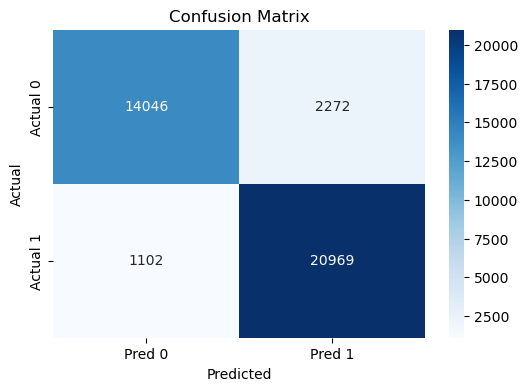

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     16318
           1       0.90      0.95      0.93     22071

    accuracy                           0.91     38389
   macro avg       0.91      0.91      0.91     38389
weighted avg       0.91      0.91      0.91     38389



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Prediksjoner
y_pred = rf_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot med seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Pred 0", "Pred 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Klassifikasjonsrapport i tekst
print(classification_report(y_test, y_pred))

In [ ]:
training_sample = pd.read_csv("../data/processed_data/sample/training_data.csv")

In [ ]:
training_sample["target"].value_counts()

target
0    361678
1    103353
Name: count, dtype: int64

In [ ]:
target
1    116553
0     75390
Name: count, dtype: int64

444735 

SyntaxError: invalid syntax (729010085.py, line 2)